# Учебная задача «Анализ сайта»

Компания «СберАвтоподписка» хочет увеличить эффективность сайта: улучшить пользовательский опыт, повысить конверсию, сделать рекламные кампании более результативными. Для этого вам предстоит **создать модель, которая предсказывает вероятность того, что пользователь совершит целевое действие (оставит заявку, закажет звонок и пр.) на сайте**.

Эта модель поможет:
- Оценивать эффективность каналов привлечения трафика;
- Адаптировать рекламные кампании;
- Улучшать UX сайта за счет анализа поведения пользователей.

## Данные
Вам предоставлен лог пользовательских действий на сайте и дополнительные данные по сессиям.
Некоторые атрибуты:
- `utm_*`, `geo_*`, `device_*` — характеристики визитов;
- `ga_hits.hit_page_path` — страницы сайта;
- `ga_sessions.utm_medium/source` — источники трафика.


## Глоссарий

- `Целевое действие` - Любое ключевое событие на сайте: Оставить заявку, Заказать звонок, Открыть диалог, и др. (ga_hits.event_action in [перечень ключей]).
- `CR (Conversion Rate)` - Конверсия — доля визитов, в которых было совершено хотя бы одно целевое действие.
- `Органический трафик` - Визиты с utm_medium in ('organic', 'referral', '(none)').
- `Платный трафик` - Все остальные типы трафика.
- `Соцсети` - Визиты с источников из набора utm_source (перечень зашифрованных ID).

# Первичный анализ данных

## Импортируем необходимые библиотеки и напишем функции

In [45]:
import numpy as np
import pandas as pd

from math import gcd
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
# настройка визуализации
%matplotlib inline
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = "retina"

In [2]:
def analyze_dataframe(df: pd.DataFrame, name: str = "DataFrame") -> None:
    """
    Функция анализирует DataFrame и выводит:
    1. Общую информацию (info)
    2. Количество пропусков по столбцам
    3. Количество полных дубликатов строк
    4. Количество уникальных значений по столбцам
    
    Параметры:
    ----------
    df : pd.DataFrame
        Анализируемый DataFrame
    name : str, optional
        Имя DataFrame для вывода (по умолчанию "DataFrame")
    """
    print(f"\n{'='*50}")
    print(f"Анализ данных: {name}, разменость ({df.shape})")
    print(f"{'='*50}\n")
    
    # 1. Вывод общей информации
    print("1. Общая информация (df.info()):")
    print(f"{'-'*45}")
    df.info()
    print(f"{'-'*45}\n")
    
    # 2. Анализ пропущенных значений
    print("2. Пропущенные значения:")
    print(f"{'-'*45}")
    missing_data = df.isna().sum()
    if missing_data.sum() > 0:
        print("Количество пропусков по столбцам:")
        print(missing_data[missing_data > 0])
        print(f"\nВсего пропусков: {missing_data.sum()}")
        print(f"Доля пропусков: {missing_data.sum() / df.size:.2%}")
    else:
        print("Пропущенных значений не обнаружено!")
    print(f"{'-'*45}\n")
    
    # 3. Поиск дубликатов
    print("3. Дубликаты:")
    print(f"{'-'*45}")
    duplicates = df.duplicated()
    if duplicates.sum() > 0:
        print(f"Найдено полных дубликатов строк: {duplicates.sum()}")
        print(f"Доля дубликатов: {duplicates.sum() / len(df):.2%}")
        print("\nПримеры дублированных строк:")
        print(df[duplicates].head())
    else:
        print("Полных дубликатов строк не обнаружено!")
    print(f"{'-'*45}\n")
    
    # 4. Анализ уникальных значений
    print("4. Уникальные значения по столбцам:")
    print(f"{'-'*45}")
    unique_stats = pd.DataFrame({
        'Уникальных': df.nunique(),
        'Доля уникальных': df.nunique() / len(df)
    })
    print(unique_stats)
    print(f"{'-'*45}\n")


In [3]:
def enhanced_missing_heatmap(df: pd.DataFrame, figsize: tuple=(14, 10), threshold: int=30) -> None:
    """
    Функция визуализирует пропуски в датафрейме и выводит по ним 
    дополнитеьную статистику
    
    Параметры:
        df: pandas DataFrame
        figsize: tuple - размер фигуры
        threshold: int - порог процента пропусков для выделения (красная пунктирная линия)
    """
    # Создаем фигуру с двумя subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, 
                                  gridspec_kw={'height_ratios': [3, 1]})
    
    # 1. Тепловая карта пропусков
    colors = ['blue', 'yellow']
    sns.heatmap(df.isnull(), 
                ax=ax1,
                cbar=False, 
                cmap=sns.color_palette(colors),
                yticklabels=False)
    ax1.set_title('Тепловая карта пропусков в данных', pad=20, fontsize=14)
    ax1.set_xlabel('')
    
    # 2. График количества пропусков по столбцам с подписями
    missing_percent = df.isnull().mean() * 100
    bars = missing_percent.plot(kind='bar', ax=ax2, color='coral', width=0.8)
    
    # Добавляем подписи процентов над каждым столбцом
    for bar in bars.patches:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10)
    
    # Линия порога и настройки графика
    ax2.axhline(y=threshold, color='red', linestyle='--', linewidth=1)
    ax2.text(len(missing_percent)*0.8, threshold + 3, 
             f'Порог {threshold}%', color='red', fontsize=10)
    
    ax2.set_title(f'Процент пропусков по столбцам (порог {threshold}%)', pad=15, fontsize=12)
    ax2.set_ylabel('% пропусков', fontsize=10)
    ax2.set_ylim(0, min(100, missing_percent.max() + 15))
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    # 3. Выводим статистику в виде текста
    total_missing = df.isnull().sum().sum()
    total_cells = df.size
    missing_ratio = total_missing / total_cells
    
    print("\n" + "="*60)
    print(f"{'СТАТИСТИКА ПРОПУСКОВ':^60}")
    print("="*60)
    print(f"Общее количество пропусков: {total_missing:,} (из {total_cells:,} ячеек)")
    print(f"Доля пропусков в данных: {missing_ratio:.2%}")
    print(f"Столбцы с пропусками: {len(missing_percent[missing_percent > 0])} из {len(df.columns)}")
    print(f"Строки с пропусками: {df.isnull().any(axis=1).sum():,} из {len(df):,} ({df.isnull().any(axis=1).mean():.1%})")
    print("="*60 + "\n")
    
    plt.show()

## GA Sessions

Одна строка = один визит на сайт.

Основная информация:
- `session_id` — уникальный идентификатор визита  
- `client_id` — уникальный идентификатор посетителя  
- `visit_date` — дата визита (ГГГГ-ММ-ДД)  
- `visit_time` — время визита (ЧЧ:ММ:СС)  
- `visit_number` — порядковый номер визита для данного клиента  

UTM-метки:
- `utm_source` — канал привлечения (вероятно, соцсети в виде зашифрованных ID)  
- `utm_medium` — тип привлечения (вероятно, тип трафика organic, cpc, referral)  
- `utm_campaign` — рекламная кампания  
- `utm_keyword` — ключевое слово (вероятно, для платного трафика)  

Характеристики устройства:
- `device_category` — тип устройства   
- `device_os` — ОС устройства 
- `device_brand` — марка устройства 
- `device_model` — модель устройства  
- `device_screen_resolution` — разрешение экрана  
- `device_browser` — используемый браузер 

Геоданные:
- `geo_country` — страна   
- `geo_city` — город  

In [4]:
# загрузим данные ga_sessions
ga_sessions = pd.read_csv('data/ga_sessions.csv')
# сохраним размерность исходного датасета
ga_sessions_shape_initial = ga_sessions.shape
ga_sessions.head()

/var/folders/82/7qspv7mx2wj5rh25ylxc2jpr0000gn/T/ipykernel_28135/1770559855.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ga_sessions = pd.read_csv('data/ga_sessions.csv')


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163775,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [5]:
# выполним первичный анализ данных
analyze_dataframe(ga_sessions, 'GA Sessions')


Анализ данных: GA Sessions, разменость ((1860042, 18))

1. Общая информация (df.info()):
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                

### Изучение явных пропусков


                    СТАТИСТИКА ПРОПУСКОВ                    
Общее количество пропусков: 4,918,396 (из 33,480,756 ячеек)
Доля пропусков в данных: 14.69%
Столбцы с пропусками: 7 из 18
Строки с пропусками: 1,845,102 из 1,860,042 (99.2%)



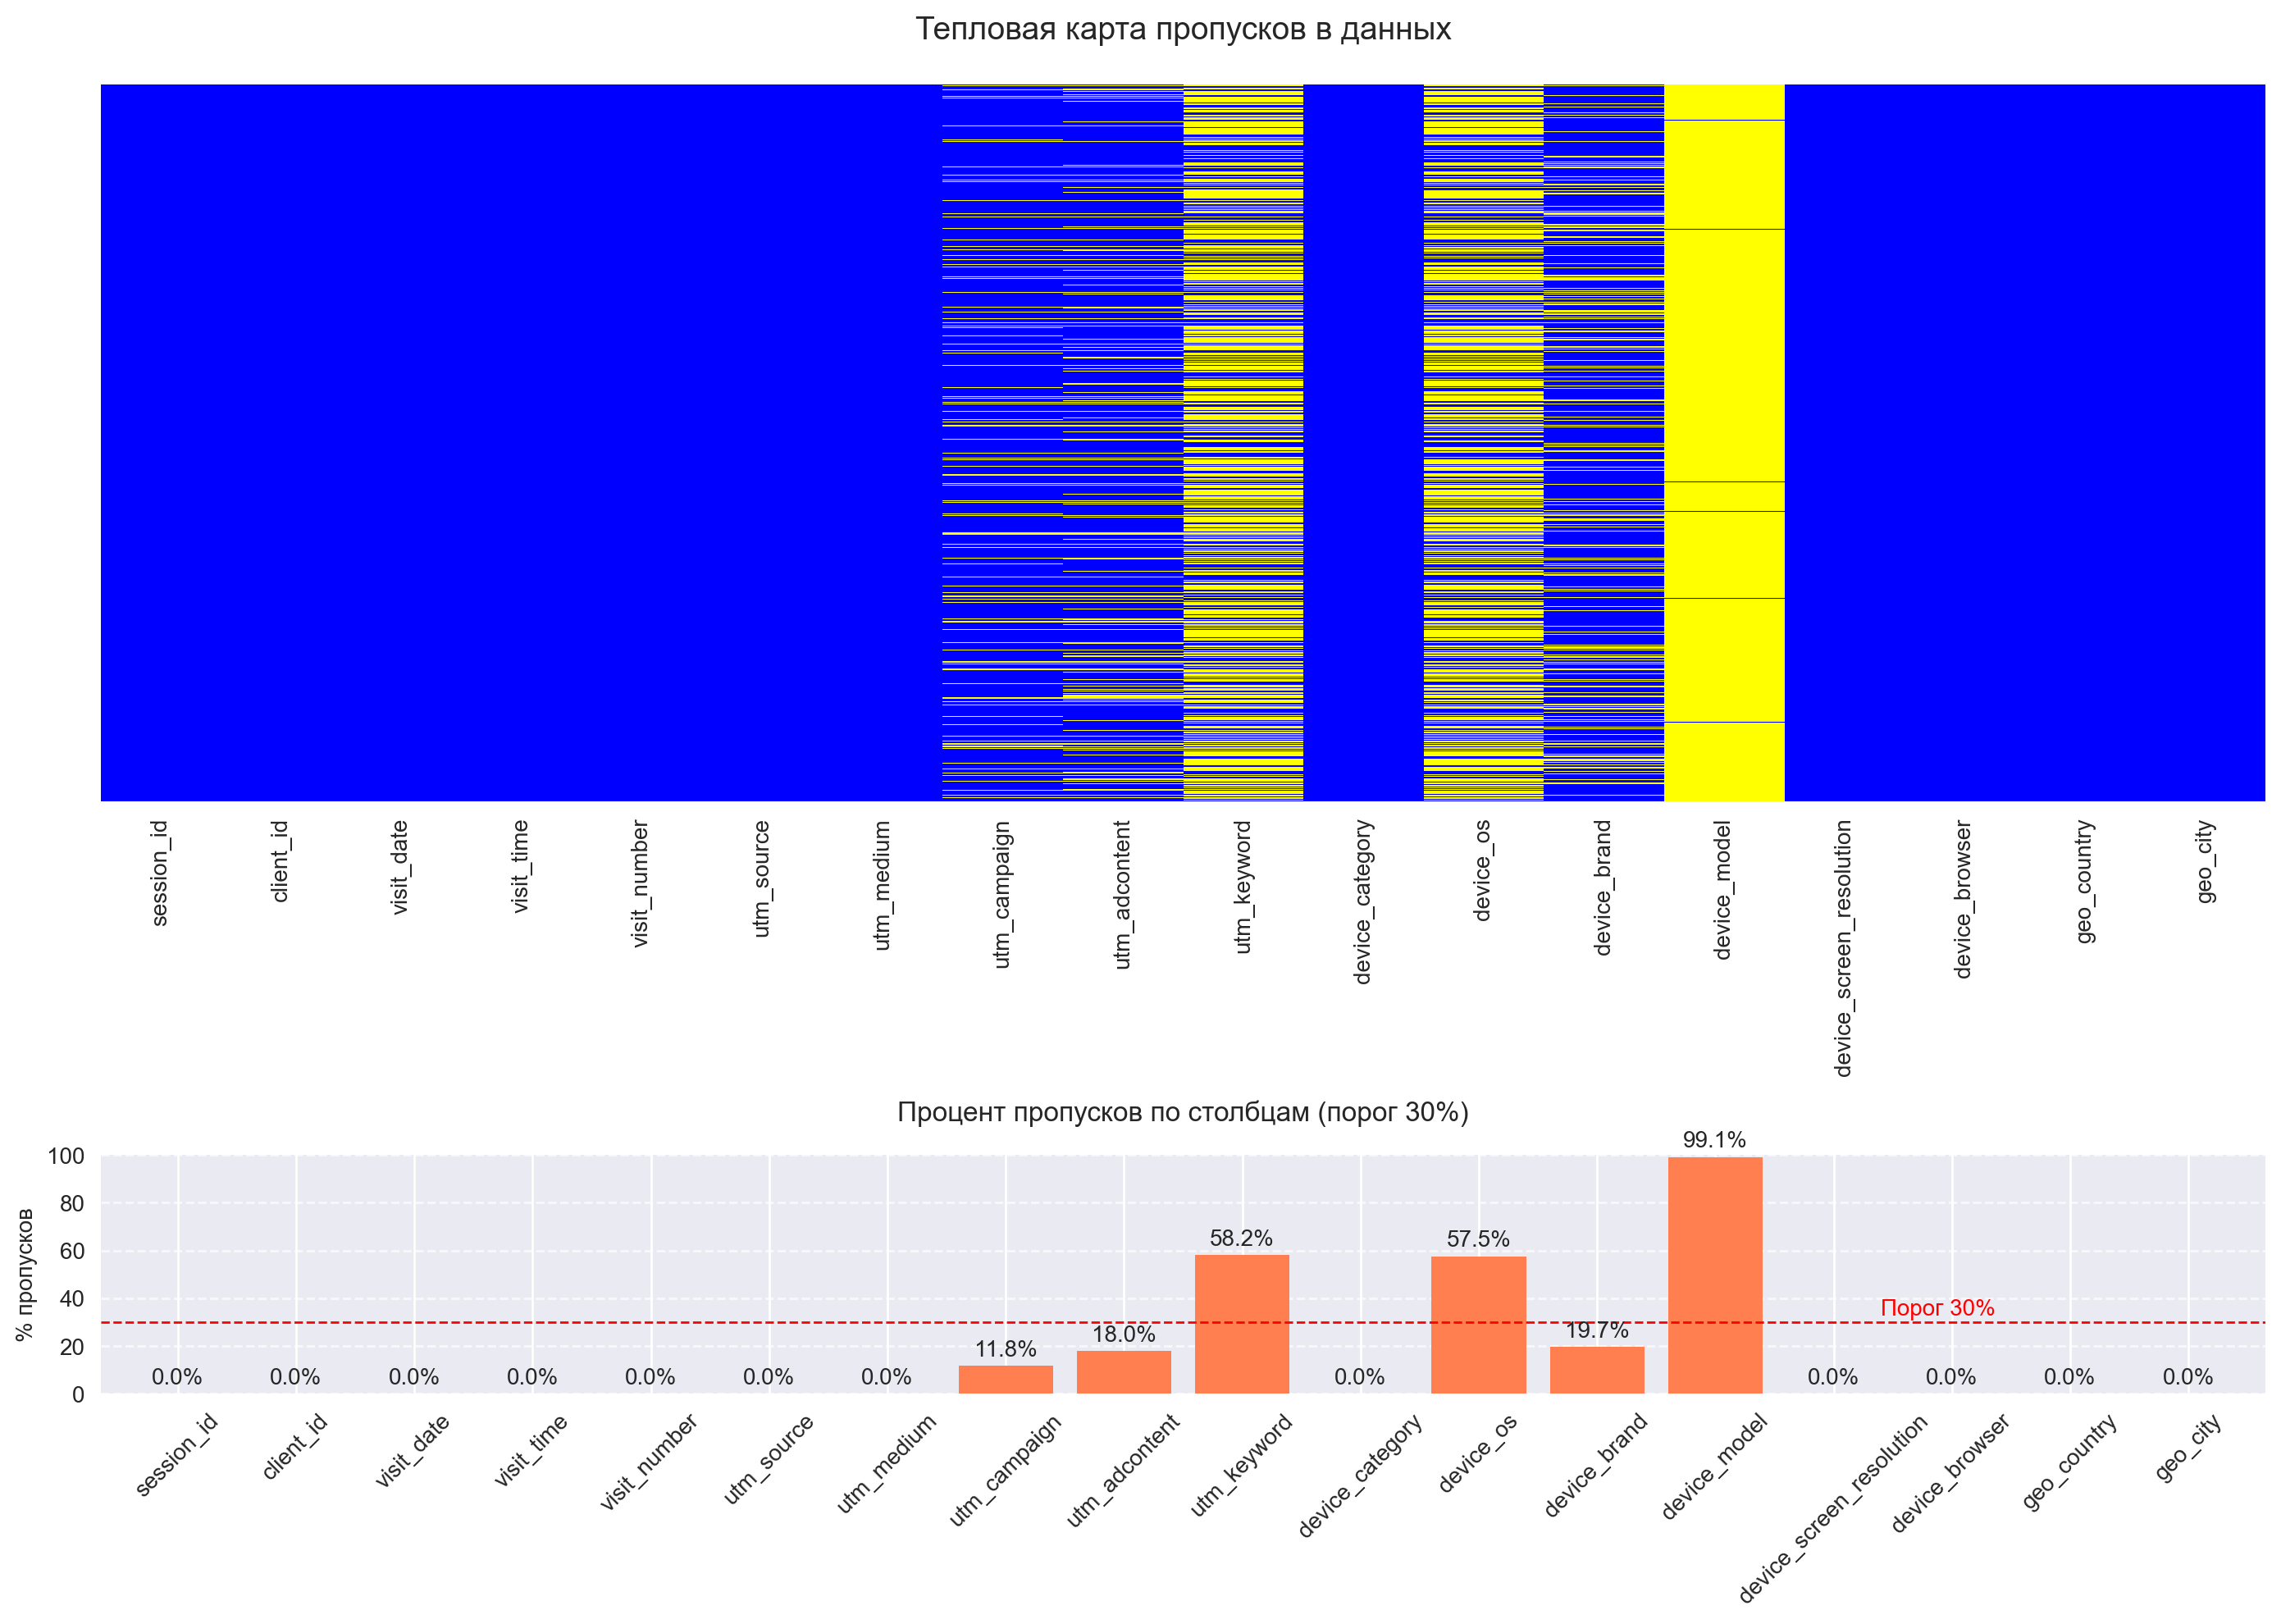

In [6]:
# подробно изучим пропуски
enhanced_missing_heatmap(ga_sessions)

### Изучение неявных пропусков

In [7]:
# выведем значения признака utm_medium 
#ga_sessions.utm_medium.value_counts(dropna=False)

В признаке `utm_medium` имеются неявные пропуски в виде значений *(none)* и *(not set)*.

In [12]:
# выведем значения признака device_brand 
#ga_sessions.device_brand.value_counts(dropna=False).index.to_list()

В признаке `device_brand` имеются неявные пропуски в виде значений *(not set)*, а так же содержаться неявные дубликаты, например 'Apple' и 'apple'.

In [10]:
# выведем значения признака device_screen_resolution
#ga_sessions.device_screen_resolution.value_counts(dropna=False).index.to_list()

В признаке `device_screen_resolution` имеются неявные пропуски в виде значений *0x0* и *(not set)*.

In [13]:
# выведем значения признака geo_city
#ga_sessions.geo_city.value_counts(dropna=False).index.to_list()

В признаке `geo_city` имеются неявные пропуски в виде значений *(not set)* и значений городов в виде цифр.

### Выводы по датасету GA Sessions:
- размерность данных (1860042, 18)
- отсутствуют полные дубликаты строк
- данные содержат большое количество пропусков:
    - 99.2% строк имеют пропуски
    - более 50% пропусков содержат признаки `utm_keyword`, `device_os`, `device_model` - удаляем.
    - также большое количество пропусков в признаках `utm_campaign`и`utm_adcontent` - проанализируем
    - признак `utm_medium` не имея явных пропусков, содержит скрытые пропуски (значения *(none)* и *(not set)* ) - заполняем пропуски
    - признак `device_screen_resolution` не имея явных пропусков, содержит скрытые пропуски (значения *0x0* и *(not set)* ) - проанализируем
    - неявные пропуски в признаках `device_brand`, `geo_city` пока не трогаем
- в признаке `device_brand` имеются неявные дубликаты (возможно, в других сходных признаках то же), что связано с прописными и строчными буквами одного и того же значения. Нада избавиться от дубликатов, переведя символы в нижний регистр.

### Работаем с пропусками

In [7]:
# удалим признаки с более 50% пропусков
ga_sessions.drop(['utm_keyword', 'device_os', 'device_model'], axis=1, inplace=True)

#### Работаем с явными пропусками в признаке `utm_source`

In [8]:
## Заполним пропуски в признаке utm_source

nan_count = ga_sessions[ga_sessions['utm_source'].isna()].shape[0]
print(f'Количество пропусков в признаке utm_source до преобразования = {nan_count}')

# создаем словарь, где ключ - client_id, значение - его первый utm_source:
#   - сбрасываем строки с пропусками в utm_source
#   - группируем оставшиеся данные по client_id и выбираем признак utm_source
#   - для каждого клиента берем первое встретившееся значение utm_source
#   - преобразует результат в словарь формата {client_id: utm_source}
client_id_utm_source = \
    ga_sessions.dropna(subset=['utm_source']).\
    groupby('client_id')['utm_source'].\
    first().\
    to_dict()
   
# заполним пропуски в признаке utm_source первым utm_source данного клиента
ga_sessions['utm_source'] = ga_sessions['utm_source'].fillna(ga_sessions['client_id'].map(client_id_utm_source))

nan_count = ga_sessions[ga_sessions['utm_source'].isna()].shape[0]
print(f'Количество пропусков в признаке utm_source после преобразования = {nan_count}')

Количество пропусков в признаке utm_source до преобразования = 97
Количество пропусков в признаке utm_source после преобразования = 7


Оставшиеся 7 строк с пропусками просто удалим.

#### Работаем с неявными пропусками в признаке `utm_medium`

In [9]:
# посмотрим на данные с неявным пропуском (none) в utm_medium
display(ga_sessions[ga_sessions['utm_medium'] == '(none)'].head())
ga_sessions[ga_sessions['utm_medium'] == '(none)'].shape

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
11,9055469620715506713.1628883994.1628883994,2108390820.162888,2021-08-13,22:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x869,Android Webview,Russia,Saint Petersburg
12,9055469620715506713.1633110583.1633110583,2108390820.162888,2021-10-01,20:00:00,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x869,Android Webview,Russia,Saint Petersburg
28,9055505230298952295.1638478433.1638478433,2108399111.163848,2021-12-02,23:53:53,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,NaN,1536x864,Chrome,Russia,Balashikha
29,9055507072827135870.1625692029.1625692029,2108399540.162569,2021-07-08,00:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x699,Chrome,Russia,Pushkino
30,9055507072827135870.1625694582.1625694582,2108399540.162569,2021-07-08,00:00:00,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x699,Chrome,Russia,Pushkino


(300575, 15)

In [10]:
## Похоже, utm_source utm_campaign utm_adcontent в пропусках одни и те же

display(ga_sessions[ga_sessions['utm_medium'] == '(none)'].utm_source.value_counts())
display(ga_sessions[ga_sessions['utm_medium'] == '(none)'].utm_campaign.value_counts())
display(ga_sessions[ga_sessions['utm_medium'] == '(none)'].utm_adcontent.value_counts())

utm_source
fDLlAcSmythWSCVMvqvL    300575
Name: count, dtype: int64

utm_campaign
LTuZkdKfxRGVceoWkVyg    300575
Name: count, dtype: int64

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    300575
Name: count, dtype: int64

Так и есть. Посмотрим на наиболее часто встречающиеся значения в признаке `utm_medium` в разрезе указанных выше признаков.

In [11]:
display(ga_sessions[ga_sessions['utm_source'] == 'fDLlAcSmythWSCVMvqvL']['utm_medium'].value_counts())
display(ga_sessions[ga_sessions['utm_campaign'] == 'LTuZkdKfxRGVceoWkVyg']['utm_medium'].value_counts())
display(ga_sessions[ga_sessions['utm_adcontent'] == 'JNHcPlZPxEMWDnRiyoBf']['utm_medium'].value_counts())

utm_medium
(none)       300575
(not set)         5
Name: count, dtype: int64

utm_medium
(none)       300575
referral     119843
organic       39447
app            2836
(not set)       480
cpc             191
partner          97
email             3
banner            3
cbaafe            2
sber_app          1
cpa               1
desktop           1
cpm               1
Name: count, dtype: int64

utm_medium
banner               371532
(none)               300575
referral             125136
cpc                   87797
organic               39454
push                  28035
email                 16402
stories               10582
blogger_channel        6232
blogger_stories        4281
tg                     4011
cpm                    3356
post                   2326
smm                    1985
outlook                1332
clicks                  934
blogger_header          771
(not set)               480
smartbanner             413
sms                     239
cpa                     213
landing                 134
partner                  97
fb_smm                   66
vk_smm                   65
link                     57
ok_smm                   28
nkp                      14
article                  12
web_polka                11
main_polka                4
cbaafe                    4
catalogue                 4
users_msk                 3
reach                     2
promo_sbe

In [12]:
# выведем моду признака utm_medium
ga_sessions['utm_medium'].mode()[0]

'banner'

In [13]:
# выясним долю значений признака (none) к длине датасета
len(ga_sessions[ga_sessions['utm_medium'] == '(none)']) / len(ga_sessions) 

0.16159581342786883

Меняем значения *none* на *banner*, т.е. на моду.

In [14]:
ga_sessions.loc[(
    ga_sessions['utm_source'] == 'fDLlAcSmythWSCVMvqvL') & 
    (ga_sessions['utm_adcontent'] == 'JNHcPlZPxEMWDnRiyoBf') & 
    (ga_sessions['utm_campaign'] == 'LTuZkdKfxRGVceoWkVyg'
     ), 'utm_medium'] = 'banner'

In [15]:
# посмотрим на данные с неявным пропуском (not set) в utm_medium
display(ga_sessions[ga_sessions['utm_medium'] == '(not set)'].head())
ga_sessions[ga_sessions['utm_medium'] == '(not set)'].shape

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
14028,9117228372811440986.1636426594.1636426594,2122770150.163642,2021-11-09,05:56:34,1,iNFgfQPqHPBuvGCYtrQE,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Huawei,360x720,Chrome,Russia,Saint Petersburg
17049,9130968089155116617.1636081226.1636081226,2125969177.163608,2021-11-05,06:00:26,1,iNFgfQPqHPBuvGCYtrQE,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,414x896,Safari,Russia,(not set)
20218,9144903415488255785.1637263046.1637263046,2129213748.163467,2021-11-18,22:17:26,3,WeIwsqEbpZGZwhcQktNS,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,OnePlus,360x800,Chrome,Russia,Moscow
20219,9144903415488255785.1637295862.1637295862,2129213748.163467,2021-11-19,07:24:22,4,WeIwsqEbpZGZwhcQktNS,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,OnePlus,360x800,Chrome,Russia,Moscow
23827,9160652639657579968.1637324018.1637324018,2132880650.163635,2021-11-19,15:13:38,3,VCREhgqUPSUkmfOTvGiW,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,NaN,1920x1080,Edge,Russia,Moscow


(475, 15)

Эти строки проще удалить - их мало.

In [16]:
ga_sessions = ga_sessions.query("utm_medium != '(not set)'")

#### Работаем с неявными пропусками в признаке `device_screen_resolution`

Выведем количество строк со значениями *(not set)* и *0x0*

In [17]:
ga_sessions[ga_sessions['device_screen_resolution'] == '(not set)'].shape

(8, 15)

In [18]:
ga_sessions[ga_sessions['device_screen_resolution'] == '0x0'].shape

(11, 15)

Строк немного - удаляем их.

In [19]:
ga_sessions = ga_sessions.query("device_screen_resolution != '(not set)'")
ga_sessions = ga_sessions.query("device_screen_resolution != '0x0'")

#### Работаем с явными пропусками в признаках `utm_campaign`и`utm_adcontent`

In [20]:
# выведем топ 10 значений признаков
display(ga_sessions.utm_campaign.value_counts(dropna=False)[:10])
display(ga_sessions.utm_adcontent.value_counts(dropna=False)[:10])

utm_campaign
LTuZkdKfxRGVceoWkVyg    463004
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247357
NaN                     219600
gecBYcKZCPMcVYdSSzKP    134042
TmThBvoCcwkCZZUWACYq     26597
XHNUiSKKGTEpSAlaVMFQ     24524
okTXSMadDkjvntEHzIjp     24510
SgIUDYUKnyWHVowUOqid     22841
sbJRYgVfvcnqKJNDDYIr     20188
Name: count, dtype: int64

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    1006115
NaN                      335613
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113071
PkybGvWbaqORmxjNunqZ      60316
LLfCasrxQzJIyuldcuWy      24221
TuyPWsGQruPMpKvRxeBF      18189
UxrnyMlRBSOhOjytXnMG      13583
dUuXlWzvmhDSyclWRhNP      10280
yYdBRbPmBMUZHXwqGxNx       9700
Name: count, dtype: int64

In [21]:
# посмотрим количество уникальных значений признаков
display(ga_sessions.utm_campaign.nunique())
display(ga_sessions.utm_adcontent.nunique())

412

286

Видно, что пропуски в топе 4 и 2 наиболее часто встречающихся значений признаков. Кроме того, эти значения - просто шифры, которые мы не можем сгруппировать по смыслу и схожести, даже если мы тем или иным способом избавимся от пропусков. Единственный вариант - сгруппировать по количеству встречаемости на 4-5 групп, но тут надо удалять строки с пропусками, т.к. значения с NaN в топе встречаемости. Еще как вариант - попробовать кластеризацию и разделить их на кластеры, но думаю, что в данной ситуации эти признаки проще удалить, что мы и сделаем.

In [22]:
ga_sessions.drop(['utm_campaign', 'utm_adcontent'], axis=1, inplace=True)

### Приведение типов и первичная обработка признаков, создание новых признаков

#### Преобразуем признаки `visit_date` и `visit_time` в соответствующие форматы времени

In [23]:
ga_sessions['visit_date'] = pd.to_datetime(ga_sessions['visit_date'], format='%Y-%m-%d')
ga_sessions['visit_time'] = pd.to_datetime(ga_sessions['visit_time'], format='%H:%M:%S').dt.time

#### Выделим из признака `device_screen_resolution` размеры сторон экрана и создадим новый признак - площадь экрана в пикселях `screen_area`, а также признак соотношения сторон экрана - `aspect_ratio`.

In [24]:
# разделение разрешения на ширину и высоту
ga_sessions[['screen_width', 'screen_height']] = ga_sessions['device_screen_resolution'].str.split('x', expand=True).astype(int)

# создание нового признака с площадью экрана
ga_sessions['screen_area'] = ga_sessions['screen_width'] * ga_sessions['screen_height']

In [25]:
# напишем короткую функцию для расчета соотношения сторон экрана
def calculate_aspect_ratio(resolution):
    '''
    Функция расчитывает соотношение сторон экрана устройства, получая на вход
    строку типа '_width_x_height_', например '1024x768'.
    Возвращает соотношение сторон в виде строки типа '_width_:_height_', например '4:3'
    либо NaN.
    '''
    try:
        # получаем из исходного признака ширину и высоту экрана
        width, height = map(int, resolution.split('x'))
        # вычисляем наибольший общий делитель (НОД)
        common_divisor = gcd(width, height)
        # получаем сокращенное соотношение
        ratio = f"{width//common_divisor}:{height//common_divisor}"
        return ratio
    except:
        return np.nan

# создадим новый признак с указанием соотношения сторон экрана устройства
ga_sessions['aspect_ratio'] = ga_sessions['device_screen_resolution'].apply(calculate_aspect_ratio)

In [26]:
# удаляем ненужные признаки
ga_sessions.drop(['device_screen_resolution', 'screen_width', 'screen_height'], axis=1, inplace=True)

#### Работаем с категориальными признаками

Избавляемся от пропусков

In [27]:
# заполняем пропуски в device_brand значением 'unknown'
ga_sessions['device_brand'] = ga_sessions['device_brand'].fillna('unknown')

In [28]:
# удалим последние строки с пропусками
ga_sessions.dropna(inplace=True)

Переводим символы в значениях в строчные (избавимся от неявных дубликатов)

In [29]:
# Выбираем только категориальные/строковые колонки
categorical_cols = ['utm_medium', 'device_category', 'device_brand', 'device_browser', 'geo_country', 'geo_city']

# Применяем преобразование к каждой колонке
for col in categorical_cols:
    ga_sessions[col] = ga_sessions[col].str.lower()

### Итоговая размерность датасета

In [30]:
ga_sessions_shape_final = ga_sessions.shape
ga_sessions_shape_initial
print(f'Начальная размерность датасета = {ga_sessions_shape_initial}')
print(f'Финальная размерность датасета = {ga_sessions_shape_final}')
print(f'Число строк уменьшилось на {(\
    ga_sessions_shape_initial[0] - ga_sessions_shape_final[0])/ga_sessions_shape_initial[0] * 100\
    } %')

Начальная размерность датасета = (1860042, 18)
Финальная размерность датасета = (1859547, 14)
Число строк уменьшилось на 0.026612302302851224 %


In [32]:
ga_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,device_category,device_brand,device_browser,geo_country,geo_city,screen_area,aspect_ratio
0,9055434745589932991.1637753792.1637753792,2108382700.163775,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,mobile,huawei,chrome,russia,zlatoust,259200,1:2
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,mobile,samsung,samsung internet,russia,moscow,328790,55:122
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,mobile,huawei,chrome,russia,krasnoyarsk,259200,1:2
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,mobile,xiaomi,chrome,russia,moscow,308898,1:2
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,mobile,xiaomi,chrome,russia,moscow,308898,1:2


***

## GA Hits 

Одна строка = один визит на сайт.

**Полное описание атрибутов:**

- **`session_id`** — ID визита  
- **`hit_date`** — дата события  
- **`hit_time`** — время события  
- **`hit_number`** — порядковый номер события в рамках сессии  
- **`hit_type`** — тип события  
- **`hit_referer`** — источник события  
- **`hit_page_path`** — страница события  
- **`event_category`** — тип действия  
- **`event_action`** — действие  
- **`event_label`** — тег действия  
- **`event_value`** — значение результата действия  

In [32]:
# загрузим данные ga_hits
ga_hits = pd.read_csv('data/ga_hits.csv')
# сохраним размерность исходного датасета
ga_hits_shape_initial = ga_hits.shape
ga_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [ ]:
# первичный анализ
analyze_dataframe(ga_hits, 'GA Hits')


Анализ данных: GA Hits, разменость ((15726470, 11))

1. Общая информация (df.info()):
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB
---------------------------------------------

2. Пропущенные значения:
---------------------------------------------
Количество пропусков по столбцам:
hit_time        9160322
hit_referer     6274804
event_label     3760184
event_value    15726470
dtype: int64

Всего пропусков: 34921780
Доля пропусков: 20.19%
--


                    СТАТИСТИКА ПРОПУСКОВ                    
Общее количество пропусков: 34,921,780 (из 172,991,170 ячеек)
Доля пропусков в данных: 20.19%
Столбцы с пропусками: 4 из 11
Строки с пропусками: 15,726,470 из 15,726,470 (100.0%)



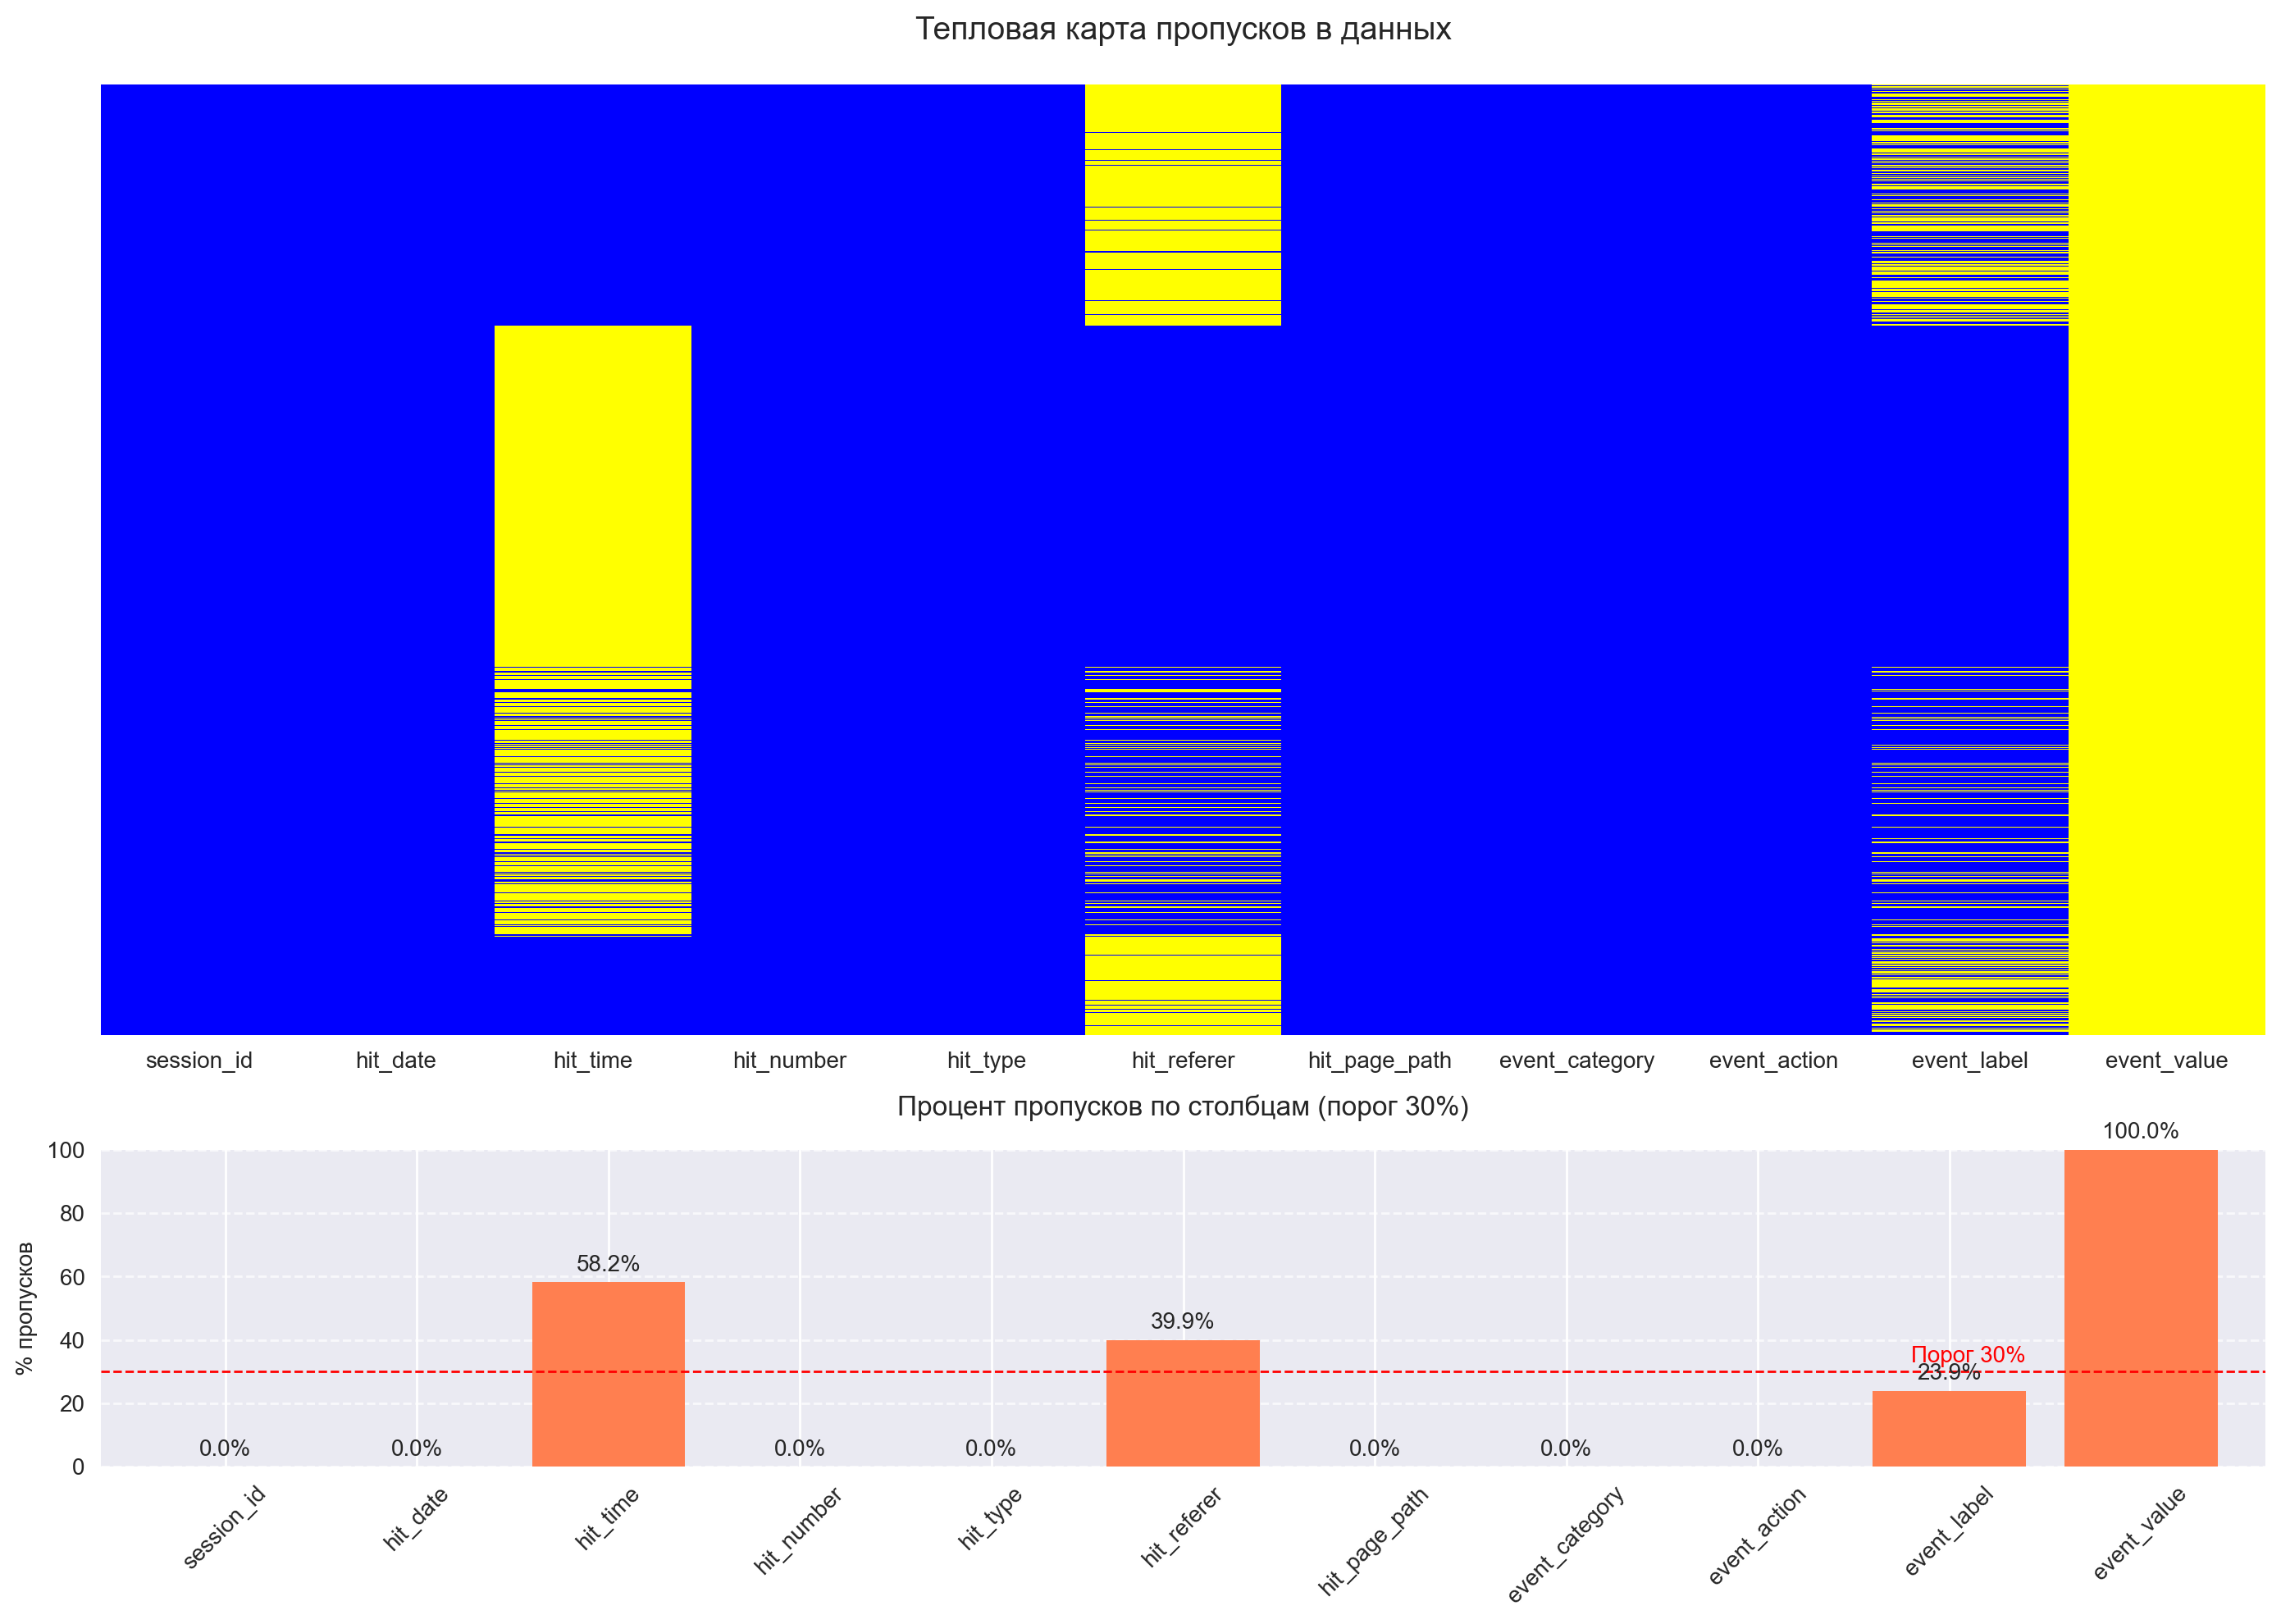

In [34]:
# первичный анализ явных пропусков
enhanced_missing_heatmap(ga_hits)

### Выводы по датасету GA Hits:
- размерность данных (15726470, 11)
- отсутствуют полные дубликаты строк
- данные содержат большое количество пропусков:
    - 100% строк имеют пропуски
    - более 50% пропусков содержат признаки `hit_time`, `event_value` - удаляем.
    - почти 40% пропусков в признаке `hit_referer`и 20% в признаке `event_label` - проанализируем
    - признак `hit_type` имеет только 1 значение - удаляем

### Анализ пропусков признаков `hit_referer` и `event_label`

In [35]:
ga_hits.hit_referer.value_counts(dropna=False)

hit_referer
HbolMJUevblAbkHClEQa    8879187
NaN                     6274804
FwdMTcXzWAwhtsnMAbhS      91940
sAGDBCdeVPmQPwkVEcIX      53565
GQmOLxANuSeCxCanBpMl      35470
                         ...   
VaOgrsicGpgIbzLNSDbc          1
rSeuBRLEcgyWsXrSYQqh          1
UNckxKWlzUxsKgvMBNdE          1
YZNVwxZKSbzYIwrGrgdY          1
tvGabHlPFDvTmIFiCKTL          1
Name: count, Length: 37874, dtype: int64

In [36]:
ga_hits.event_label.value_counts(dropna=False)

event_label
KclpemfoHstknWHFiLit    6505447
NaN                     3760184
hAHqGICPFQiPwtzubOzs    1284914
OHfyUfDKdPgBdvelDlfG     626554
pzAKUYdRKNEUXxxBFUPX     358915
                         ...   
iFTveknOEiHmdgIHHqBZ          1
WKfoFxrMANSjHQMIhCZr          1
RAJXTkPWctNbMZubUIng          1
jRptuMMybqHerOxplPYo          1
aNlmojNIfsJaXKZHCDiU          1
Name: count, Length: 39826, dtype: int64

Пропуски - 2-е по частоте значение данных признаков. Сами признаки имеют очень большое количество уникальных значений, которые представлены шифром, что делает крайне затруднительной возможность группировать эти значения. Группировка по количеству значений также затрудниетльна - пропуски на 2-м месте по их количеству. Так же удаляем данные признаки.

In [37]:
ga_hits.drop(['hit_time', 'event_value', 'hit_referer', 'event_label', 'hit_type'], axis=1, inplace=True)

### Извлекаем полезную информацию из признака `hit_page_path`

In [38]:
# выведем топ-20 по встречаемости признаков
ga_hits['hit_page_path'].value_counts()[:20]

hit_page_path
podpiska.sberauto.com/                                                                                                                                                                                                  2793639
sberauto.com/cars?city=1&rental_page=rental_only&rental_car=rental_only&city=18                                                                                                                                         1103484
sberauto.com/cars?utm_source_initial=sbol&utm_medium_initial=banner&utm_campaign_initial=LEoPHuyFvzoNfnzGgfcd&utm_content_initial=vCIpmpaGBnIQhyYNkXqp&city=1&rental_page=rental_only&rental_car=rental_only&city=18     754215
sberauto.com/cars/f28947a1?rental_page=rental_car                                                                                                                                                                        264878
sberauto.com/cars/bf24b977?rental_page=rental_car                                         

Ссылка типа 'sberauto.com/cars/all/skoda/rapid/bf24b977?rental_page=rental_car' ведет страницу с автомобилем Skoda Rapid. Выделим марки авто из данного типа строк:

In [39]:
ga_hits['car_brand'] = ga_hits['hit_page_path'].str.extract(r'/cars/all/([^/?]+)')
ga_hits['car_brand'] = ga_hits['car_brand'].fillna('unknown')
ga_hits.car_brand.value_counts()

car_brand
unknown          12311655
skoda              744516
mercedes-benz      472316
volkswagen         417128
lada-vaz           403910
nissan             238701
kia                236270
bmw                195404
toyota             160840
renault            150656
porsche             63569
lexus               61631
audi                60035
volvo               51627
haval               51538
mini                34709
peugeot             27431
land-rover          24872
hyundai             19054
honda                 397
infiniti              211
Name: count, dtype: int64

In [40]:
# удаляем hit_page_path
ga_hits.drop(['hit_page_path'], axis=1, inplace=True)

### Итоговая размерность датасета

In [41]:
ga_hits_shape_final = ga_hits.shape
ga_hits_shape_initial
print(f'Начальная размерность датасета = {ga_hits_shape_initial}')
print(f'Финальная размерность датасета = {ga_hits_shape_final}')
print(f'Число строк уменьшилось на {(\
    ga_hits_shape_initial[0] - ga_hits_shape_final[0])/ga_hits_shape_initial[0] * 100\
    } %')

Начальная размерность датасета = (15726470, 11)
Финальная размерность датасета = (15726470, 6)
Число строк уменьшилось на 0.0 %


***

## Предварительный анализ таргета - признак `event_action`

In [42]:
# топ-20 значений признака
ga_hits.event_action.value_counts()[:20]

event_action
view_card                             3558985
view_new_card                         3551009
sub_landing                           1798117
go_to_car_card                         973666
sub_view_cars_click                    791515
search_form_region                     512069
search_form_search_btn                 433748
sap_search_form_cost_to                356596
showed_number_ads                      326274
pagination_click                       248944
search_form_mark_select                222652
quiz_show                              214037
search_form_model_select               211890
sap_search_form_cost_from              188129
photos_all                             181493
search_form_search_car_type_select     174877
photos                                 158543
sub_car_page                           130310
view_more_click                        109971
search_kpp                              79465
Name: count, dtype: int64

In [43]:
# число уникальных значений
ga_hits.event_action.nunique()

230

Вот список действий, которые отобрал Deepseek, относящихся к категориям "Оставить заявку", "Заказать звонок" и "Открыть диалог":

In [44]:
target_actions = [
    'sub_car_claim_submit_click',        # Оставить заявку
    'sub_car_request_submit_click',      # Оставить заявку
    'sub_callback_submit_click',         # Заказать звонок
    'sub_open_dialog_click',             # Открыть диалог
    'start_chat',                        # Открыть диалог
    'open_offer',                        # Оставить заявку (предложение)
    'form_request_call_sent',            # Заказать звонок
    'callback requested',                # Заказать звонок
    'phone_entered',                     # Оставить заявку (с телефоном)
    'sub_submit_success',                # Успешная отправка заявки
    'chat requested',                    # Открыть диалог
    'client initiate chat',              # Открыть диалог
    'click_on_request_call',             # Заказать звонок
    'show_phone_input',                  # Оставить заявку (показать поле телефона)
    'name_entered',                      # Оставить заявку (с именем)
    'phone_entered_on_form_request_call' # Заказать звонок
]

Сгруппируем сессии, добавим признак `target`куда внесем значение = True, если за эту сесию было хотя бы одно целевое действие из *target_actions* и False, если таких действий не было. Выполним агрегацию оставшихся признаков.

In [49]:
# заполняем ga_hits['target'] 'True', если ga_hits['event_action'] содержит целевое действие
ga_hits['target'] = ga_hits['event_action'].isin(target_actions) 

ga_hits_final = (
    # группируем по session_id
    ga_hits.groupby('session_id')
    .agg({
        # вычисляем кол-во event_category в данном session_id 
        'event_category': lambda x: len(x.astype(str).tolist()),  
        # рассчитываем медиану сгрупированных значений hit_number
        'hit_number': 'median',  
        # собираем в список car_brand  
        'car_brand': lambda x: x.astype(str).tolist(),
        # если хотя бы один раз в сессию был target = True, то ставим True
        'target': 'any'                            
    })
    .reset_index()
    # переименовываем колонки
    .rename(columns={
        'event_category': 'event_categories_number',
        'hit_number' : 'hit_number_median',
        'car_brand' : 'car_brands_list'
        })
)

# избавляемся от 'unknown' в списках признака car_brands_list
ga_hits_final['car_brands_list'] = ga_hits_final['car_brands_list'].apply(
    lambda x: list(filter(lambda b: b != 'unknown', x)) if isinstance(x, list) else []
)


In [50]:
def get_most_common(car_brands_list):
    '''
    Функция принимает на вход список с названиями марок авто и возвращает 
    наиболее часто встречающуюся марку авто в виде строки.
    Если входящий список пустой - возвращает 'none'
    '''
    if not isinstance(car_brands_list, list) or len(car_brands_list) == 0:
        return 'none'
    return Counter(car_brands_list).most_common(1)[0][0]

# получаем наиболее популярную марку авто, которой интересовался пользователь в данной сессии
ga_hits_final['top_car_brand'] = ga_hits_final['car_brands_list'].apply(get_most_common)

ga_hits_final.drop(['car_brands_list'], axis=1, inplace=True)

In [51]:
ga_hits_final

,session_id,event_categories_number,hit_number_median,target,top_car_brand
0,1000009318903347362.1632663668.1632663668,10,9.5,False,none
1,1000010177899156286.1635013443.1635013443,6,7.5,False,none
2,1000013386240115915.1635402956.1635402956,11,10.0,False,lada-vaz
3,1000017303238376207.1623489300.1623489300,12,10.5,False,none
4,1000020580299877109.1624943350.1624943350,1,3.0,False,none
...,...,...,...,...,...
1734605,999960188766601545.1626816843.1626816843,1,3.0,False,none
1734606,99996598443387715.1626811203.1626811203,2,3.5,False,none
1734607,999966717128502952.1638428330.1638428330,12,12.0,False,none
1734608,999988617151873171.1623556243.1623556243,4,5.5,False,none


Теперь получим соотношение значений таргета:

In [52]:
ga_hits_final.target.value_counts(dropna=False, normalize=True).apply(lambda x: f'{x:0.2%}')

target
False    95.23%
True      4.77%
Name: proportion, dtype: object

***

## Собираем итоговый датасет

In [56]:
print('Размерность датасета GA_Sessions и GA_Hits: ', ga_sessions.shape, ' и ' ,ga_hits_final.shape)

Размерность датасета GA_Sessions и GA_Hits:  (1859547, 14)  и  (1734610, 5)


In [69]:
final_dataset = pd.merge(ga_hits_final, ga_sessions, on='session_id', how='left')

In [70]:
final_dataset.dropna(inplace=True)
final_dataset.drop(['session_id'], axis=1, inplace=True)

In [73]:
final_dataset.shape

(1731856, 17)

In [75]:
final_dataset.to_csv('data/dataset.csv', index=False)

***

## Выводы
- представленные наборы данных **`ga_sessions`** и **`ga_hits`** были проанализированы и очищены от пропусков:
    - удалены признаки `utm_keyword`, `device_os`, `device_model`, `hit_time`, `event_value` т.к. содержали более 50% пропущенных значений
    - также удалены признаки `utm_campaign`, `utm_adcontent`, `hit_referer`, `event_label`, т.к. заполнение их пропусков было принято нецелесообразным
    - явные пропуски в признаке `utm_source` были в большинстве своем заполнены
    - неявные пропуски в признаке `utm_medium` были в большинстве своем заполнены
    - неявные пропуски в признаке `device_screen_resolution` были удалены
    - неявные пропуски в признаке `device_brand` были обработаны
    - размер датасета **`ga_sessions`** уменьшился менее 1%, размер **`ga_hits`** не изменился
- неявные дубликаты в категориальных признаках, связанные с регистром симоволов были устранены
- были созданы новые признаки:
    - из признака `device_screen_resolution` были получены признаки `screen_area` и `aspect_ratio`, исходный признак удален
    - из признака `hit_page_path` был извлеен признак `car_brand`, исходный признак удален
- из признака `event_action` был выделен таргет, исходный признак удален
- датасет **`ga_hits`** был сгруппирован по признаку `session_id`, если в данную сессию было выполнено хотя бы одно целевое действие (таргет) - значение сгруппированного таргета принимается за *True*. Значения остальных признаков при группировке были агрегированы.
- из набора данных **`ga_sessions`** и сгруппированного **`ga_hits`** было составлен окончательный датасет для EDA и моделирования.